# TA-11 — Implementasi **Gaussian Naive Bayes** (Dataset: *Heart Disease - heart.csv*)

Notebook ini mengikuti instruksi TA-11 pada modul:
- Load dataset  
- Encoding (wajib) untuk fitur kategorikal **jika ada kolom teks**  
- **StandardScaler (krusial)** untuk fitur numerik (khusus GaussianNB)  
- Split data 80/20  
- Training GaussianNB  
- Evaluasi (Confusion Matrix & Accuracy)  
- Analisis probabilitas (`predict_proba`)  
- Simulasi 2 data dummy kontras  

> **Dataset**: *heart.csv*  
> Target: `target` (0/1)  
> Semua kolom umumnya sudah numerik, sehingga encoding teks biasanya **tidak diperlukan** (tetap dicek di notebook).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

pd.set_option("display.max_columns", 100)


## 1) Load Data
Simpan file CSV di folder yang sama dengan notebook ini, atau ubah `DATA_PATH`.

In [2]:
DATA_PATH = "heart.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## 2) Pemeriksaan Awal Data

In [3]:
print("Info:")
df.info()

print("\nMissing values per kolom:")
display(df.isna().sum())

print("\nStatistik numerik:")
display(df.describe(include=[np.number]).T)


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB

Missing values per kolom:


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


Statistik numerik:


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


## 3) Preprocessing (Encoding jika ada kolom teks)
Sesuai instruksi TA: jika ada kolom bertipe `object` (teks), lakukan `LabelEncoder`.

In [4]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Kolom kategorikal (object):", cat_cols)

gender_mapping = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    gender_mapping[col] = dict(zip(le.classes_, le.transform(le.classes_)))

if len(gender_mapping) > 0:
    print("Mapping LabelEncoder:", gender_mapping)

display(df.head())


Kolom kategorikal (object): []


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## 4) Visualisasi Distribusi Fitur (KDE Plot)
Cek sebaran beberapa fitur numerik terhadap target (`target`).

> Catatan: Ini KDE sederhana dengan pandas/matplotlib.

Kolom untuk KDE: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


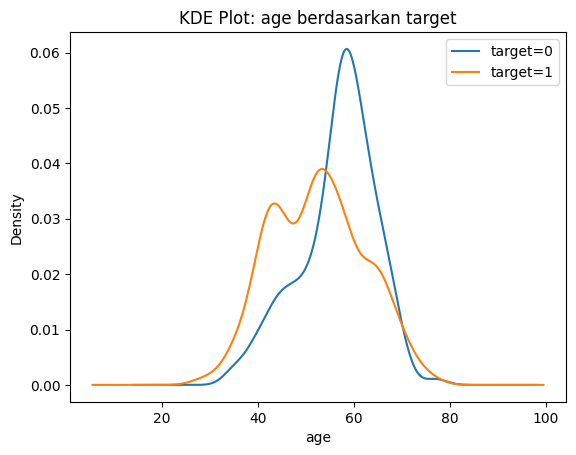

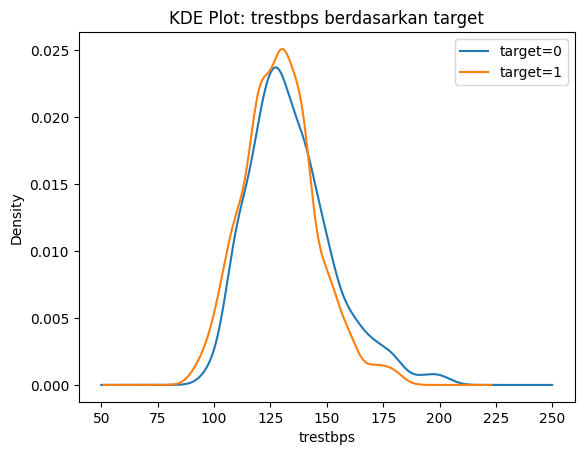

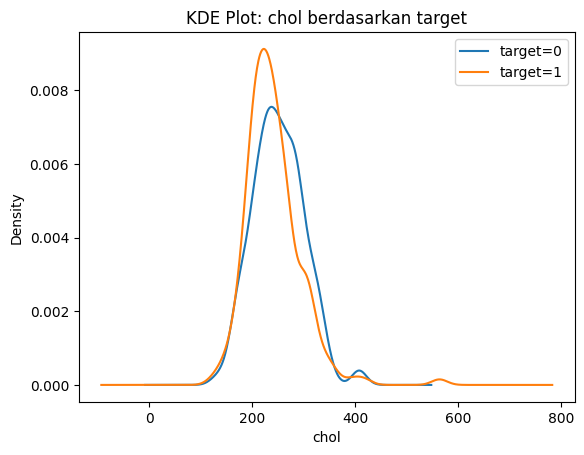

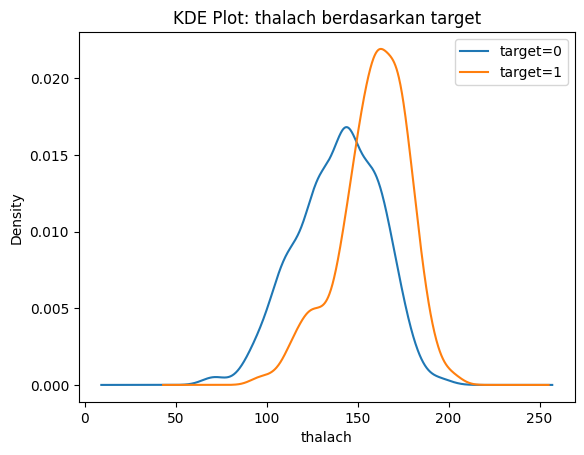

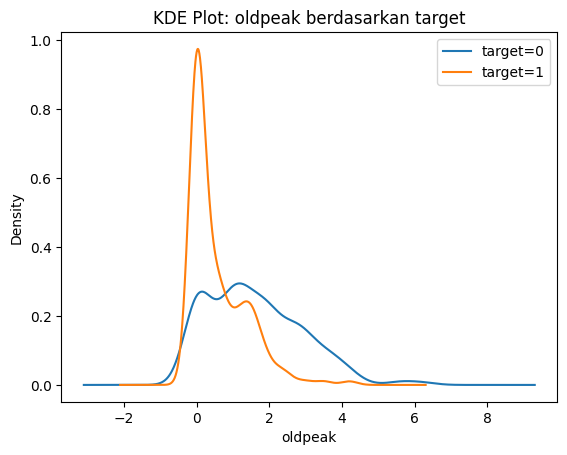

In [5]:
target_col = "target"
assert target_col in df.columns, f"Kolom target '{target_col}' tidak ditemukan."

# Pilih beberapa fitur numerik umum pada dataset heart (sesuaikan jika kolom Anda berbeda)
candidate_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
num_cols = [c for c in candidate_cols if c in df.columns]

print("Kolom untuk KDE:", num_cols)

for col in num_cols:
    plt.figure()
    for cls in sorted(df[target_col].unique()):
        subset = df.loc[df[target_col] == cls, col].astype(float)
        subset.plot(kind="kde", label=f"{target_col}={cls}")
    plt.title(f"KDE Plot: {col} berdasarkan {target_col}")
    plt.xlabel(col)
    plt.legend()
    plt.show()


## 5) Split Data (80/20) & Feature Scaling (StandardScaler)
Karena dataset heart umumnya **semua numerik**, kita melakukan scaling pada semua fitur agar sesuai instruksi GaussianNB.

In [6]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_features = X.columns.tolist()  # semua fitur numerik

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_features)],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GaussianNB())
])

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)
clf


Train shape: (820, 13) (820,)
Test shape : (205, 13) (205,)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'sex', 'cp',
                                                   'trestbps', 'chol', 'fbs',
                                                   'restecg', 'thalach',
                                                   'exang', 'oldpeak', 'slope',
                                                   'ca', 'thal'])])),
                ('model', GaussianNB())])

## 6) Training Gaussian Naive Bayes

In [7]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print("Selesai training & prediksi.")


Selesai training & prediksi.


## 7) Evaluasi Standar: Confusion Matrix & Accuracy

Accuracy: 0.8292682926829268

Classification Report:
              precision    recall  f1-score   support

           0     0.8571    0.7800    0.8168       100
           1     0.8070    0.8762    0.8402       105

    accuracy                         0.8293       205
   macro avg     0.8321    0.8281    0.8285       205
weighted avg     0.8315    0.8293    0.8288       205



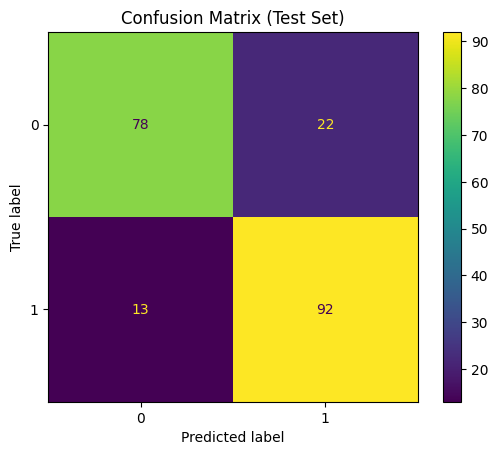

In [8]:
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
disp.plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()


## 8) Analisis Probabilitas (`predict_proba`) pada 1 Sampel
Ambil 1 sampel test yang salah diprediksi (jika ada), jika tidak ambil sampel acak.

In [9]:
wrong_idx = np.where(y_pred != y_test.values)[0]

if len(wrong_idx) > 0:
    i = wrong_idx[0]
    source = "salah diprediksi (misclassified)"
else:
    i = np.random.randint(len(X_test))
    source = "acak (tidak ada misclassified pada test set ini)"


sample_raw = X_test.iloc[i:i+1]
true_label = int(y_test.iloc[i])

pred_class = int(clf.predict(sample_raw)[0])
proba = clf.predict_proba(sample_raw)[0]  # [P(class0), P(class1)]
confidence = float(np.max(proba) * 100)

print("Sampel dipilih:", source)
print("\nFitur sampel (raw):")
display(sample_raw)
print("True label:", true_label)
print("Predicted :", pred_class)
print("Probabilities [P(0), P(1)]:", proba)
print(f"Keyakinan model (max proba): {confidence:.2f}%")

if confidence >= 90:
    print("Interpretasi: Model sangat yakin terhadap prediksi ini (>= 90%).")
elif confidence <= 60:
    print("Interpretasi: Model cenderung ragu (<= 60%).")
else:
    print("Interpretasi: Keyakinan model sedang (60%–90%).")


Sampel dipilih: salah diprediksi (misclassified)

Fitur sampel (raw):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
353,57,1,0,110,201,0,1,126,1,1.5,1,0,1


True label: 1
Predicted : 0
Probabilities [P(0), P(1)]: [0.99153627 0.00846373]
Keyakinan model (max proba): 99.15%
Interpretasi: Model sangat yakin terhadap prediksi ini (>= 90%).


## 9) Simulasi Prediksi Data Baru (2 Data Dummy Kontras)
Untuk kasus heart:
- **Dummy A (risiko rendah)**: umur lebih muda, tekanan darah/kolesterol lebih rendah, oldpeak rendah
- **Dummy B (risiko tinggi)**: umur lebih tua, tekanan darah/kolesterol lebih tinggi, oldpeak lebih tinggi

> Nilai dummy dibuat berbasis median agar realistis, lalu beberapa fitur utama dioverride.

In [10]:
feature_cols = X_train.columns.tolist()
median_row = X.median(numeric_only=True)

def make_sample(overrides: dict):
    s = median_row.copy()
    for k, v in overrides.items():
        if k in s.index:
            s[k] = v
    return pd.DataFrame([s], columns=feature_cols)

dummy_A = make_sample({
    "age": 29,
    "trestbps": 110,
    "chol": 170,
    "thalach": 175,
    "oldpeak": 0.0
})

dummy_B = make_sample({
    "age": 62,
    "trestbps": 150,
    "chol": 260,
    "thalach": 125,
    "oldpeak": 2.4
})

dummy = pd.concat([dummy_A.assign(sample="A"), dummy_B.assign(sample="B")], ignore_index=True)
display(dummy[["sample"] + feature_cols[:min(8, len(feature_cols))]])

dummy_pred = clf.predict(dummy.drop(columns=["sample"]))
dummy_proba = clf.predict_proba(dummy.drop(columns=["sample"]))

print("--- Hasil Prediksi Dummy ---")
for idx, (row, pred, proba) in enumerate(zip(dummy.drop(columns=["sample"]).to_dict("records"), dummy_pred, dummy_proba), start=1):
    print(f"Dummy {idx}: {row}")
    print(f"  Prediksi kelas: {int(pred)}")
    print(f"  Probabilitas [P(0), P(1)]: {proba} | Keyakinan: {np.max(proba)*100:.2f}%")


,sample,age,sex,cp,trestbps,chol,fbs,restecg,thalach
0,A,29.0,1.0,1.0,110.0,170.0,0.0,1.0,175.0
1,B,62.0,1.0,1.0,150.0,260.0,0.0,1.0,125.0


--- Hasil Prediksi Dummy ---
Dummy 1: {'age': 29.0, 'sex': 1.0, 'cp': 1.0, 'trestbps': 110.0, 'chol': 170.0, 'fbs': 0.0, 'restecg': 1.0, 'thalach': 175.0, 'exang': 0.0, 'oldpeak': 0.0, 'slope': 1.0, 'ca': 0.0, 'thal': 2.0}
  Prediksi kelas: 1
  Probabilitas [P(0), P(1)]: [3.63530245e-04 9.99636470e-01] | Keyakinan: 99.96%
Dummy 2: {'age': 62.0, 'sex': 1.0, 'cp': 1.0, 'trestbps': 150.0, 'chol': 260.0, 'fbs': 0.0, 'restecg': 1.0, 'thalach': 125.0, 'exang': 0.0, 'oldpeak': 2.4, 'slope': 1.0, 'ca': 0.0, 'thal': 2.0}
  Prediksi kelas: 0
  Probabilitas [P(0), P(1)]: [0.90704858 0.09295142] | Keyakinan: 90.70%


## 10) Kesimpulan (Template untuk Laporan PDF)
Silakan sesuaikan angka-angkanya dengan output notebook:
- Dataset heart memiliki target biner `target` (0/1), sehingga cocok untuk klasifikasi.
- Karena fitur dominan berupa angka kontinu, varian yang tepat adalah **Gaussian Naive Bayes**.
- Preprocessing mencakup pengecekan encoding (jika ada kolom teks) dan **StandardScaler** untuk fitur numerik.
- Evaluasi dilakukan dengan **Accuracy** dan **Confusion Matrix**.
- `predict_proba` digunakan untuk melihat tingkat keyakinan model (mis. 99% sangat yakin, ~51% ragu).
- Dari uji 2 data dummy kontras, bandingkan probabilitasnya untuk menilai fitur mana yang tampak lebih dominan (mis. usia/kolesterol/tekanan darah/oldpeak).
